In [ ]:
import pandas as pd
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path("/content/drive/MyDrive/Colab Notebooks/scored_news_data.csv")

In [ ]:
tmp = pd.read_csv(path)

In [ ]:
df= tmp.copy()

In [ ]:
df.shape

(135435, 6)

In [ ]:
# --- keep a version where both scores are available (for correlation etc.) ---
pair_df = df.dropna(subset=["sent_score_xlm", "sent_score_finbert"]).copy()


In [ ]:
pair_df.head()

,date,ticker,language,text,sent_score_xlm,sent_score_finbert
0,2024-02-23,ABB,de,Rosengren nimmt bei ABB den Hut und übergibt a...,0.010688,0.999740
1,2022-09-30,ABB,de,ABB trennt sich von restlichem Stromnetz-Gesch...,-0.053976,0.999977
2,2023-05-19,ABB,de,Fitness-Pionier übergibt an Sohn Im April 1989...,-0.391919,0.008612
3,2024-03-27,ABB,de,Eine Kita in der eigenen Firma Die Dottiker Sc...,-0.038528,0.999985
4,2021-07-02,ABB,de,Das neue Highlight in der Startup-Szene: Die S...,0.047593,0.999917


In [ ]:
pair_df.shape

(110640, 6)

In [ ]:
n_total = len(df)
n_pair  = len(pair_df)

mean_xlm  = pair_df["sent_score_xlm"].mean()
std_xlm   = pair_df["sent_score_xlm"].std()
mean_fin  = pair_df["sent_score_finbert"].mean()
std_fin   = pair_df["sent_score_finbert"].std()

# Correlations (drop NaNs already handled by pair_df)
pearson_r, pearson_p = pearsonr(pair_df["sent_score_xlm"], pair_df["sent_score_finbert"])
spearman_rho, spearman_p = spearmanr(pair_df["sent_score_xlm"], pair_df["sent_score_finbert"])

# Difference diagnostics
diff     = pair_df["sent_score_finbert"] - pair_df["sent_score_xlm"]
abs_diff = diff.abs()

summary = {
    "n_rows_total": n_total,
    "n_rows_pairwise": n_pair,
    "mean_xlm": mean_xlm,
    "std_xlm": std_xlm,
    "mean_finbert": mean_fin,
    "std_finbert": std_fin,
    "pearson_r": pearson_r,
    "pearson_p": pearson_p,
    "spearman_rho": spearman_rho,
    "spearman_p": spearman_p,
    "mean_diff_finbert_minus_xlm": diff.mean(),
    "std_diff": diff.std(),
    "mean_abs_diff": abs_diff.mean(),
}

# Pretty print
print("=== Overall benchmark (XLM-R vs FinBERT) ===")
for k, v in summary.items():
    if isinstance(v, (float, np.floating)):
        print(f"{k:>28}: {v: .4f}")
    else:
        print(f"{k:>28}: {v}")

=== Overall benchmark (XLM-R vs FinBERT) ===
                n_rows_total: 135435
             n_rows_pairwise: 110640
                    mean_xlm: -0.2253
                     std_xlm:  0.2265
                mean_finbert:  0.8499
                 std_finbert:  0.3302
                   pearson_r:  0.3047
                   pearson_p:  0.0000
                spearman_rho:  0.4052
                  spearman_p:  0.0000
 mean_diff_finbert_minus_xlm:  1.0752
                    std_diff:  0.3388
               mean_abs_diff:  1.0832


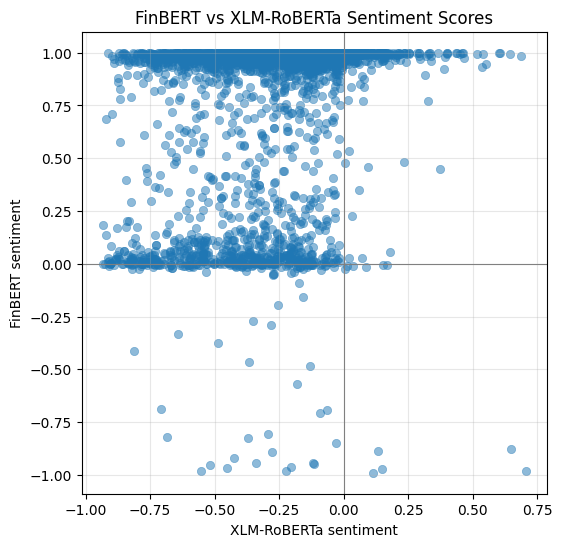

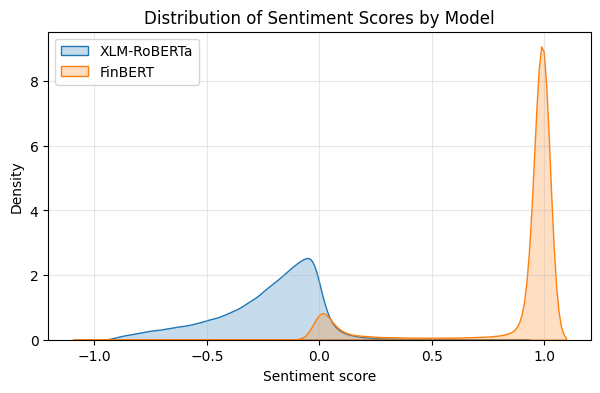

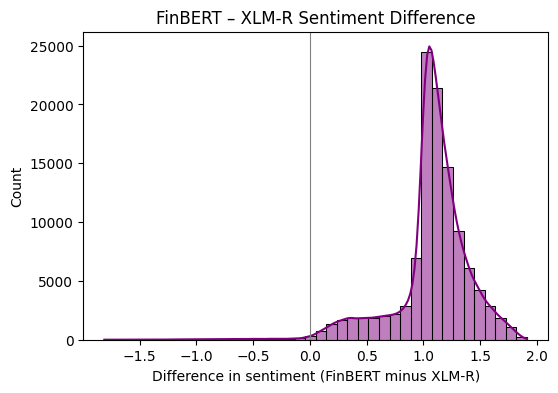

In [ ]:
# === Chunk 3 — Visual benchmark of FinBERT vs XLM-RoBERTa ===

import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Scatter plot: one point per article ---
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=pair_df.sample(min(5000, len(pair_df))),  # sample if large
    x="sent_score_xlm", y="sent_score_finbert",
    alpha=0.5, edgecolor=None
)
plt.title("FinBERT vs XLM-RoBERTa Sentiment Scores")
plt.xlabel("XLM-RoBERTa sentiment")
plt.ylabel("FinBERT sentiment")
plt.axhline(0, color="gray", lw=0.8)
plt.axvline(0, color="gray", lw=0.8)
plt.grid(alpha=0.3)
plt.show()

# --- 2) Distributions (histograms / KDE) ---
plt.figure(figsize=(7,4))
sns.kdeplot(pair_df["sent_score_xlm"], label="XLM-RoBERTa", fill=True)
sns.kdeplot(pair_df["sent_score_finbert"], label="FinBERT", fill=True)
plt.title("Distribution of Sentiment Scores by Model")
plt.xlabel("Sentiment score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 3) Difference histogram ---
pair_df["diff"] = pair_df["sent_score_finbert"] - pair_df["sent_score_xlm"]
plt.figure(figsize=(6,4))
sns.histplot(pair_df["diff"], bins=40, kde=True, color="purple")
plt.title("FinBERT – XLM-R Sentiment Difference")
plt.xlabel("Difference in sentiment (FinBERT minus XLM-R)")
plt.axvline(0, color="gray", lw=0.8)
plt.show()


In [ ]:
# === Chunk 5 — Statistical significance tests ===
from scipy.stats import ttest_rel, wilcoxon, normaltest
import numpy as np

# Make sure pair_df is defined
assert "pair_df" in globals(), "Run previous chunks first."

x = pair_df["sent_score_xlm"].dropna()
y = pair_df["sent_score_finbert"].dropna()

# Align indexes (just in case)
aligned = pair_df.dropna(subset=["sent_score_xlm", "sent_score_finbert"])
x, y = aligned["sent_score_xlm"], aligned["sent_score_finbert"]

# --- 1️⃣ Paired t-test (parametric) ---
t_stat, p_ttest = ttest_rel(y, x, nan_policy='omit')

# --- 2️⃣ Wilcoxon signed-rank test (non-parametric) ---
try:
    w_stat, p_wilcox = wilcoxon(y - x)
except ValueError:
    w_stat, p_wilcox = np.nan, np.nan  # fallback if sample too large for exact test

# --- 3️⃣ Normality check of difference (to justify parametric test) ---
diff = y - x
stat_norm, p_norm = normaltest(diff)

print("=== Statistical Tests: FinBERT vs XLM-RoBERTa ===")
print(f"Sample size (paired)          : {len(diff):,}")
print(f"Mean difference (FinBERT - XLM): {diff.mean(): .4f}")
print(f"Std difference                 : {diff.std(): .4f}")
print()
print(f"Normality test p-value         : {p_norm: .4e}  → {'Normal' if p_norm>0.05 else 'Non-normal'}")
print(f"Paired t-test p-value          : {p_ttest: .4e}")
print(f"Wilcoxon signed-rank p-value   : {p_wilcox: .4e}")


=== Statistical Tests: FinBERT vs XLM-RoBERTa ===
Sample size (paired)          : 110,640
Mean difference (FinBERT - XLM):  1.0752
Std difference                 :  0.3388

Normality test p-value         :  0.0000e+00  → Non-normal
Paired t-test p-value          :  0.0000e+00
Wilcoxon signed-rank p-value   :  0.0000e+00


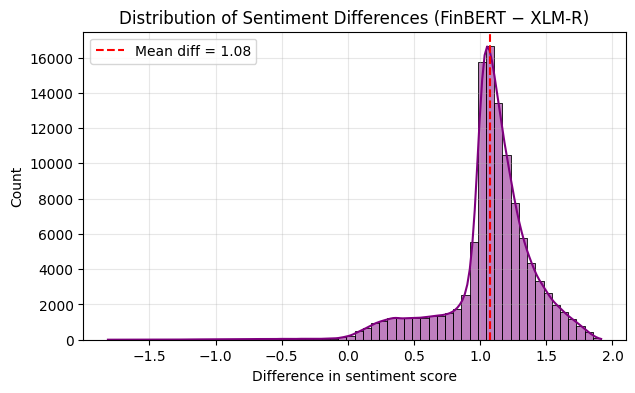

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.histplot(diff, bins=60, kde=True, color="purple")
plt.title("Distribution of Sentiment Differences (FinBERT − XLM-R)")
plt.xlabel("Difference in sentiment score")
plt.axvline(diff.mean(), color="red", linestyle="--", label=f"Mean diff = {diff.mean():.2f}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
pair_df.head()

,date,ticker,language,text,sent_score_xlm,sent_score_finbert,diff
0,2024-02-23,ABB,de,Rosengren nimmt bei ABB den Hut und übergibt a...,0.010688,0.999740,0.989052
1,2022-09-30,ABB,de,ABB trennt sich von restlichem Stromnetz-Gesch...,-0.053976,0.999977,1.053953
2,2023-05-19,ABB,de,Fitness-Pionier übergibt an Sohn Im April 1989...,-0.391919,0.008612,0.400531
3,2024-03-27,ABB,de,Eine Kita in der eigenen Firma Die Dottiker Sc...,-0.038528,0.999985,1.038513
4,2021-07-02,ABB,de,Das neue Highlight in der Startup-Szene: Die S...,0.047593,0.999917,0.952324


In [ ]:
# Example diagnostic check
high_finbert = pair_df.nlargest(20, "sent_score_finbert")[["text","sent_score_xlm","sent_score_finbert"]]
low_finbert  = pair_df.nsmallest(20, "sent_score_finbert")[["text","sent_score_xlm","sent_score_finbert"]]


In [ ]:
high_finbert

,text,sent_score_xlm,sent_score_finbert
122339,Mit der Übernahme der Volksbank begann der gro...,-0.221825,0.999988
7077,Versicherer - Baloise verkauft Spital-Haftpfli...,-0.052581,0.999988
16695,† Rosa Küng Cham Rosa Küng wurde am 12. Januar...,-0.060402,0.999988
19730,Er schrieb das Grundlagenwerk zur Lokalgeschic...,-0.118782,0.999988
53412,Richemont stellt sich weiterhin gegen VR-Wahl ...,-0.130288,0.999988
58430,Die Invalidenversicherung unter den Musikinstr...,-0.170869,0.999988
4850,Generationenwechsel bei Wetter-Gruppe Stetten ...,-0.028473,0.999988
7117,NACHRICHTEN Die Baloise Group hat das Nichtleb...,0.041517,0.999988
17152,† Josef Zurkirchen-Sager Littau/Luzern Sepp wu...,-0.102520,0.999988
28306,Nun saniert die Erzo die Abwasserrohre Sieben ...,-0.122970,0.999988


In [ ]:
# Save to CSV for manual review
high_finbert.to_csv("/content/drive/MyDrive/Colab Notebooks/top20_finbert_positive.csv", index=False)
low_finbert.to_csv("/content/drive/MyDrive/Colab Notebooks/bottom20_finbert_negative.csv", index=False)